# DoubleML binary outcome/treatment variables with EconML


* Y - outcome variable
* T - treatment variable
* X - features to describe the heterogeneous effect of T
* W - confounders that model T and Y

Model options:

* LinearDML - fits a linear regression to the y_resid ~ t_resid.
  * `est.summary()` returns stats models summary output.
  * SparseLinearDML - uses Lasso to make the residual model sparse in features. Then runs a normal unregularised model to get parameter estimates.
* DML - fits any model to the residuals

Binary treatments:

* What does `discrete_treatment=True` do?
  * OHE treatment feature. Runs `predict_proba` to get continuous predictions for less noisy residuals.
* Marginal effect of logistic model - find derivative by limits and theoretical

Model methods:

* `est.effect` - HTE for each row of data, from the T=0 to T=1, E{Y|T=1} - E{Y|T=0}, where 0 and 1 are parameters
* `est.const_marginal_effect` - E{dy/dt}
* `est.ate_inference` - distribution estimate for ATE

TODO:

* Binary outcome
  * Compare with logistic regression
  * DoubleML, causal forests, linear regression
* Difference between est.effect and est.const_marginal_effect
  * effect is E{Y|T=1} - E{Y|T=0}, where 0 and 1 are parameteres
  * const_marginal_effect is E{dy/dt}.
* Is the average marginal effect useful?
  * Does it simply relate to change in average probability.
  * How does this relate to orthogonalisation/residuals for binary outcomes

Ref:
https://arxiv.org/pdf/1806.04823.pdf

https://github.com/py-why/EconML/issues/204

In [1]:
import numpy as np
import pandas as pd
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use("seaborn-whitegrid")


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_48495/2907140941.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


## Create dummy data

In [2]:
import numpy as np
import pandas as pd


def logit(p):
    return np.log(p) - np.log(1 - p)


def inv_logit(p):
    return np.exp(p) / (1 + np.exp(p))


def no_confound(x: np.array):
    return np.zeros(x.shape[0])


def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


def generate_treatment_data(
    n_samples: int = 1000,
    n_features: int = 4,
    treatment_binary: bool = False,
    seed: int = None,
    confounding_fcn: callable = None,
    treatment_noise: float = 0.1,
):
    if confounding_fcn is None:
        confounding_fcn = no_confound

    rand = np.random.default_rng(seed)

    # generate random features
    x = rand.normal(
        loc=rand.normal(size=n_features),
        scale=rand.exponential(size=n_features),
        size=(n_samples, n_features),
    )

    t_x = confounding_fcn(x)
    if treatment_binary:
        t = rand.binomial(n=1, p=inv_logit(t_x), size=n_samples)
    else:
        t = treatment_noise * rand.normal(size=n_samples) + t_x

    x = np.concatenate([t[:, np.newaxis], x], axis=1)

    t_col = "t"
    x_cols = [f"x_{idx+1}" for idx in range(n_features)]

    return pd.DataFrame(data=x, columns=[t_col] + x_cols), t_col, x_cols


def generate_outcome_data(
    x: pd.DataFrame,
    outcome_binary: bool = False,
    outcome_noise: float = 0.1,
    seed: int = None,
    bias: float = None,
    weights: np.array = None,
):
    rand = np.random.default_rng(seed)

    n_samples, n_features = x.shape
    if bias is None:
        bias = rand.normal()
    if weights is None:
        weights = rand.normal(size=(n_features, 1))
    y = bias + np.dot(x, weights) + outcome_noise * rand.normal()

    if outcome_binary:
        y_avg = inv_logit(y)
        y = rand.binomial(n=1, p=y_avg, size=(n_samples, 1))
    else:
        y_avg = None

    return y, bias, weights, y_avg


## Linear case

In [3]:
import statsmodels.api as sm

# generate data
x_df, t_col, x_cols = generate_treatment_data(
    treatment_binary=False,
    confounding_fcn=linear_confound,
)
y, bias, weights, _ = generate_outcome_data(
    x=x_df,
    outcome_binary=False,
)

print("True weights")
print(weights.flatten())


# fit models
linear_model = sm.OLS(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est weights, all features:")
print(np.array(linear_model.params)[1:])

linear_model = sm.OLS(y, sm.add_constant(x_df[t_col])).fit()
print("Est weights, missing confounders, biased results:")
print(np.array(linear_model.params)[1:])


True weights
[-0.66644204 -1.26932072  0.69125851 -1.29907362 -0.12368614]
Est weights, all features:
[-0.66644204 -1.26932072  0.69125851 -1.29907362 -0.12368614]
Est weights, missing confounders, biased results:
[-1.65159953]


### Estimate marginal effects
The marginal effect represents the change in `y` given a unit change in the treatment `t` (or the features `x` as well).

We calculate this by estimating derivatives in `y` for each feature to represent the average marginal effects.

The results are, as expected, approximately equal to the estimate linear regression coefficients.

In [4]:
def get_marginal_effects(x, d_x: float = 1.0, model_fcn=None):
    d_y = []
    for col in x.columns:
        _x = x.copy()
        _x[col] = _x[col] + d_x
        d_y.append((model_fcn(_x) - model_fcn(x)).mean() / d_x)

    return d_y


print("True est. marginal effects:")
print(get_marginal_effects(
    x=x_df,
    model_fcn=lambda x: generate_outcome_data(
        x, outcome_binary=False, bias=bias, weights=weights
    )[0],
)
)

True est. marginal effects:
[-0.7175070149594382, -1.3662379966877605, 0.6109896869932004, -1.2814124592175842, -0.20305156035555677]


### Double ML

Assume all features are confounders.
Assume no features for CATE.

We can use GBMs for the models for `y` and `t` without creating bias.
We get similar results if we use linear regression for these.

As the data is generated from a linear model, linear regression is the ideal model to use, so we get slightly worse results with GBMs.

In [5]:
import econml.dml
import sklearn.ensemble
import sklearn.linear_model


est = econml.dml.LinearDML(
    model_t=sklearn.linear_model.LinearRegression(),
    model_y=sklearn.linear_model.LinearRegression(),
)
est.fit(Y=y, T=x_df[t_col], X=None, W=x_df.drop(columns=t_col))

print("True weights")
print(weights.flatten())

print("Est marginal effect - linear models")
display(est.const_marginal_ate_inference())


est = econml.dml.LinearDML(
    model_t=sklearn.ensemble.GradientBoostingRegressor(),
    model_y=sklearn.ensemble.GradientBoostingRegressor(),
)
est.fit(Y=y, T=x_df[t_col], X=None, W=x_df.drop(columns=t_col))

print("Est marginal effect - GBMs")
display(est.const_marginal_ate_inference())


True weights
[-0.66644204 -1.26932072  0.69125851 -1.29907362 -0.12368614]
Est marginal effect - linear models


Est marginal effect - GBMs


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


So we have agreement for the treatment effect over linear regression, doubleML and this matches the average marginal effect.

## Binary outcome case

In this case the linear model coefficients are not the same as the average marginal effect.

Here, the marginal effect is the average change in probability of observing a positive outcome.

As the binary outcome introduces a lot of noise we increase the number of samples to get reasonable accuracy.

Here we see that the linear regression coefficients do not match the data weights, as expected.
The logistic regression model is the correct model to use and we recover the data weights without bias.

In [6]:
# generate data
x_df, t_col, x_cols = generate_treatment_data(
    treatment_binary=False, confounding_fcn=linear_confound, n_samples=int(1e6)
)
y, bias, weights, y_avg = generate_outcome_data(
    x=x_df,
    outcome_binary=True,
)

print("True weights")
print(weights.flatten())

# fit models
linear_model = sm.OLS(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est weights, linear regression:")
print(np.array(linear_model.params)[1:])

logit_model = sm.Logit(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est weights, logistic regression:")
print(np.array(logit_model.params)[1:])


True weights
[-0.9472637  -1.04958304  0.36575762 -0.55934008  0.14960836]
Est weights, linear regression:
[-0.09378732 -0.09702345  0.04885977 -0.05307445  0.01347277]
Optimization terminated successfully.
         Current function value: 0.303572
         Iterations 8
Est weights, logistic regression:
[-0.99324547 -1.00649433  0.52079477 -0.55554298  0.14199388]


However if we find the average marginal effect from the logistic model we get the linear regression coefficients.

We use the average `y` to calculate the true marginal effects as it reduces the noise a lot.

In [7]:
print("True est. marginal effects:")
marginal_effects = get_marginal_effects(
        x=x_df,
        model_fcn=lambda x: generate_outcome_data(
            x, outcome_binary=True, bias=bias, weights=weights
        )[-1],
    )
print(marginal_effects)


print("Average marginal effect, logistic regression:")
print(logit_model.get_margeff().margeff)

print("Est weights, linear regression:")
print(np.array(linear_model.params)[1:])


True est. marginal effects:
[-0.10551380659801635, -0.10663643734060893, 0.04220600989768209, -0.05774247839383016, 0.008472299678372083]
Average marginal effect, logistic regression:
[-0.09478056 -0.09604484  0.0496969  -0.05301275  0.01354978]
Est weights, linear regression:
[-0.09378732 -0.09702345  0.04885977 -0.05307445  0.01347277]


Therefore if we are interested in the average marginal effects we don't need to use logistic regression.

This opens the door to use doubleML with regressors to estimate the average marginal effect even if we have binary outcomes.

In [8]:
if 1:
    est = econml.dml.LinearDML(
        model_t=sklearn.ensemble.HistGradientBoostingRegressor(),
        model_y=sklearn.ensemble.HistGradientBoostingRegressor(),
    )
else:
    est = econml.dml.LinearDML(
        model_t=sklearn.linear_model.LinearRegression(),
        model_y=sklearn.linear_model.LinearRegression(),
    )
est.fit(Y=y, T=x_df[t_col], X=None, W=x_df.drop(columns=t_col))

print("True est. marginal effects:")
print(marginal_effects)

print("Est marginal effect")
display(est.const_marginal_ate_inference())


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


True est. marginal effects:
[-0.10551380659801635, -0.10663643734060893, 0.04220600989768209, -0.05774247839383016, 0.008472299678372083]
Est marginal effect


## Binary treatment case

If we have a binary treatment the final model should be a linear regression.

Here the marginal effects are equal to the data weights.

In [9]:
# generate data
x_df, t_col, x_cols = generate_treatment_data(
    treatment_binary=True, confounding_fcn=linear_confound, n_samples=int(1e6)
)
y, bias, weights, y_avg = generate_outcome_data(
    x=x_df,
    outcome_binary=False,
)

print("True weights")
print(weights.flatten())


# fit models
linear_model = sm.OLS(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est weights, linear regression:")
print(np.array(linear_model.params)[1:])

print("True est. marginal effects:")
marginal_effects = get_marginal_effects(
        x=x_df,
        model_fcn=lambda x: generate_outcome_data(
            x, outcome_binary=False, bias=bias, weights=weights
        )[0],
    )
print(marginal_effects)


True weights
[ 1.33361479 -0.08419714  0.90394426 -0.31595414 -0.67961278]
Est weights, linear regression:
[ 1.33361479 -0.08419714  0.90394426 -0.31595414 -0.67961278]
True est. marginal effects:
[1.2793661642005925, -0.14316434021496607, 1.085837526936305, -0.1247946346771265, -0.3380430155906445]


And we see that using regression based double ML returns the same marginal effect back:

In [10]:
if 1:
    est = econml.dml.LinearDML(
        model_t=sklearn.ensemble.HistGradientBoostingRegressor(),
        model_y=sklearn.ensemble.HistGradientBoostingRegressor(),
    )
else:
    est = econml.dml.LinearDML(
        model_t=sklearn.linear_model.LinearRegression(),
        model_y=sklearn.linear_model.LinearRegression(),
    )
est.fit(Y=y, T=x_df[t_col], X=None, W=x_df.drop(columns=t_col))

print("True est. marginal effects:")
print(marginal_effects)

print("Est marginal effect")
display(est.const_marginal_ate_inference())


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


True est. marginal effects:
[1.2793661642005925, -0.14316434021496607, 1.085837526936305, -0.1247946346771265, -0.3380430155906445]
Est marginal effect


## Binary outcome and treatment case

We see that the marginal effect from a logistic model, linear regression coefficient and the data marginal effect match well.

In [11]:
# generate data
x_df, t_col, x_cols = generate_treatment_data(
    treatment_binary=True, confounding_fcn=linear_confound, n_samples=int(1e6)
)
y, bias, weights, y_avg = generate_outcome_data(
    x=x_df,
    outcome_binary=True,
)

print("True weights")
print(weights.flatten())

print("True est. marginal effects:")
marginal_effects = get_marginal_effects(
        x=x_df,
        model_fcn=lambda x: generate_outcome_data(
            x, outcome_binary=True, bias=bias, weights=weights
        )[-1],
    )
print(marginal_effects)


# fit models
linear_model = sm.OLS(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est weights, linear regression:")
print(np.array(linear_model.params)[1:])

logit_model = sm.Logit(y, sm.add_constant(x_df[[t_col] + x_cols])).fit()
print("Est weights, logistic regression:")
print(np.array(logit_model.params)[1:])

print("Average marginal effect, logistic regression:")
print(logit_model.get_margeff().margeff)


True weights
[-1.25151007 -0.2003404   0.52405794  0.57911581  0.083691  ]
True est. marginal effects:
[-0.2188815537451468, -0.016806711234567354, 0.06059341024063537, 0.10874086496559053, 0.009107245285797094]
Est weights, linear regression:
[-0.26963846 -0.03711653  0.10040592  0.10817466  0.01592634]
Optimization terminated successfully.
         Current function value: 0.555221
         Iterations 6
Est weights, logistic regression:
[-1.25347109 -0.20045781  0.53734648  0.57779394  0.08497437]
Average marginal effect, logistic regression:
[-0.23463796 -0.03752381  0.10058619  0.10815757  0.0159064 ]


And we see that using regression based double ML returns the same marginal effect back:

In [12]:
est = econml.dml.LinearDML(
    model_t=sklearn.ensemble.HistGradientBoostingRegressor(),
    model_y=sklearn.ensemble.HistGradientBoostingRegressor(),
)
est.fit(Y=y, T=x_df[t_col], X=None, W=x_df.drop(columns=t_col))

print("True est. marginal effects:")
print(marginal_effects)

print("Est marginal effect")
display(est.const_marginal_ate_inference())


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


True est. marginal effects:
[-0.2188815537451468, -0.016806711234567354, 0.06059341024063537, 0.10874086496559053, 0.009107245285797094]
Est marginal effect


# TODO


### With confounders

Linear regression gives biased outcomes when ignoring x_1 the confounder

In [13]:
def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


df, bias, weights, x_cols = generate_data(
    treatment_binary=False,
    outcome_binary=False,
    confounding_fcn=linear_confound,
    outcome_noise=1.0,
    treatment_noise=0.1,
)

print("True weights")
print(bias)
print(weights.flatten())


linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[x_cols], y=df["y"])
print("Est weights (ignore confounder)")
print(linear_model.intercept_)
print(linear_model.coef_)

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)


NameError: name 'generate_data' is not defined

Residualise treatment with features

In [ ]:
treatment_model = sklearn.linear_model.LinearRegression()
treatment_model.fit(X=df[x_cols], y=df["t"])
print("Est weights")
print(treatment_model.intercept_)
print(treatment_model.coef_)

df = df.drop(columns=["t_resid"], errors="ignore")
df = df.assign(t_resid=df["t"] - treatment_model.predict(df[x_cols]))


NameError: name 'df' is not defined

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2777063384.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/2777063384.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


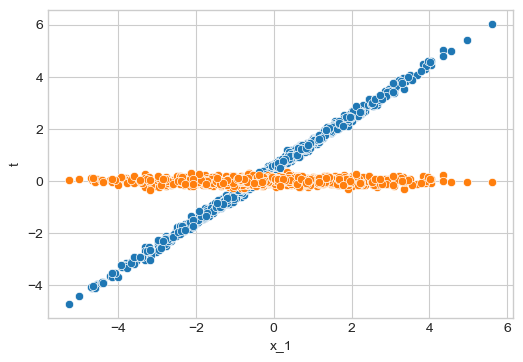

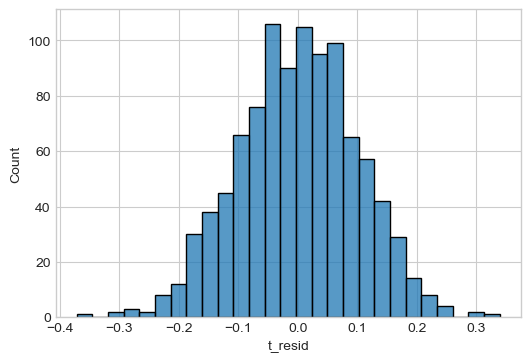

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="t", x="x_1", ax=ax)
sns.scatterplot(data=df, y="t_resid", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="t_resid", ax=ax)
fig.show()


Residualise outcome

In [ ]:
outcome_model = sklearn.linear_model.LinearRegression()
outcome_model.fit(X=df[x_cols], y=df["y"])
print("Est weights")
print(outcome_model.intercept_)
print(outcome_model.coef_)

df = df.drop(columns=["y_resid"], errors="ignore")
df = df.assign(y_resid=df["y"] - outcome_model.predict(df[x_cols]))


Est weights
-0.3376103421569753
[ 0.93726718  0.6645215  -0.15172712 -0.60710827]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/1686059054.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/1686059054.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


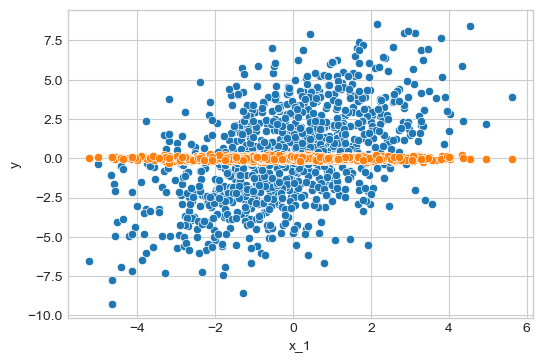

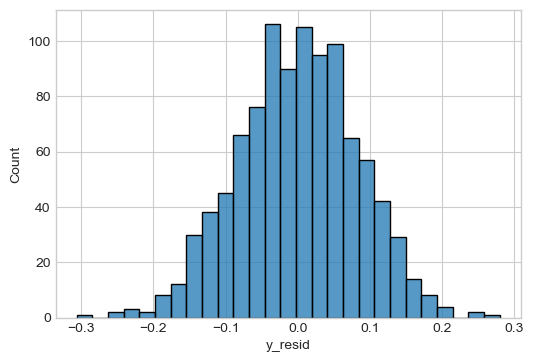

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y", x="x_1", ax=ax)
sns.scatterplot(data=df, y="y_resid", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="y_resid", ax=ax)
fig.show()


Model on residuals

In [ ]:
residuals_model = sklearn.linear_model.LinearRegression()
residuals_model.fit(X=df[["t_resid"]], y=df["y_resid"])

print("True weights")
print(bias)
print(weights.flatten())

print("Est weights")
print(residuals_model.intercept_)
print(residuals_model.coef_)

df = df.drop(columns=["yt_resid"], errors="ignore")
df = df.assign(yt_resid=df["y_resid"] - residuals_model.predict(df[["t_resid"]]))


True weights
-0.6086835973443033
[ 0.82431597  0.11390388  0.66203475 -0.14398739 -0.60797301]
Est weights
1.6340025297892289e-16
[0.82431597]


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/563212422.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_59387/563212422.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


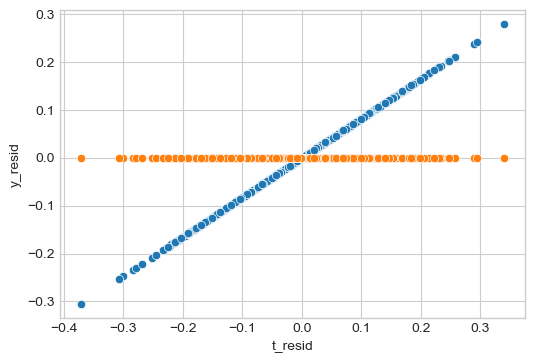

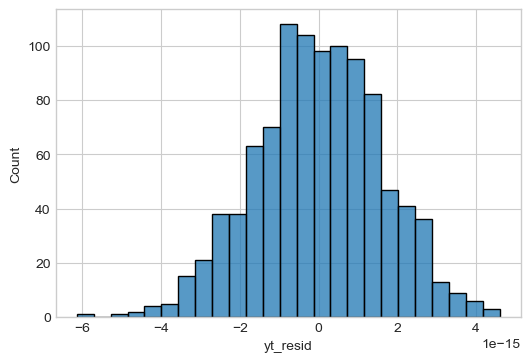

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y_resid", x="t_resid", ax=ax)
sns.scatterplot(data=df, y="yt_resid", x="t_resid", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="yt_resid", ax=ax)
fig.show()


## Binary outcome case

In [ ]:
def linear_confound(x: np.array, a: float = 1.0, b: float = 0.5):
    return a * x[:, 0] + b


df, bias, weights, x_cols = generate_data(
    treatment_binary=False,
    outcome_binary=True,
    confounding_fcn=linear_confound,
    outcome_noise=1.0,
    treatment_noise=0.1,
)

print("True weights")
print(bias)
print(weights.flatten())


linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[x_cols], y=df["y"])
print("Est weights (ignore confounder)")
print(linear_model.intercept_)
print(linear_model.coef_)

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)


True weights
-0.3117738001983923
[-0.76856054  0.31923465  0.51529586  1.24731644  2.18529629]
Est weights (ignore confounder)
0.5659284999348831
[-0.03957463  0.09066578  0.11675159  0.20757683]
Est weights
0.6147350557217326
[-0.09964713  0.06011852  0.08929568  0.11662495  0.20737488]


Residualise treatment with features

In [ ]:
treatment_model = sklearn.linear_model.LinearRegression()
treatment_model.fit(X=df[x_cols], y=df["t"])
print("Est weights")
print(treatment_model.intercept_)
print(treatment_model.coef_)

df = df.drop(columns=["t_resid"], errors="ignore")
df = df.assign(t_resid=df["t"] - treatment_model.predict(df[x_cols]))


Est weights
0.4897938797803085
[ 1.00046179 -0.0137496  -0.00127088 -0.00202661]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


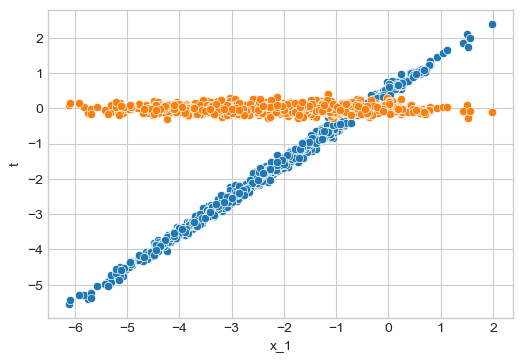

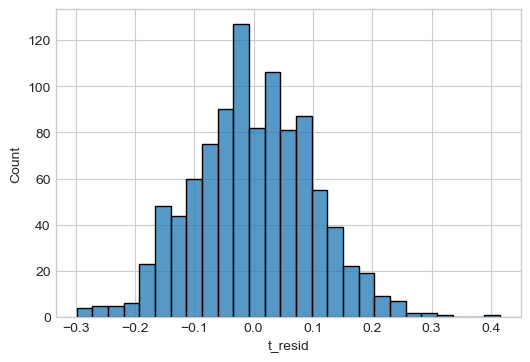

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="t", x="x_1", ax=ax)
sns.scatterplot(data=df, y="t_resid", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="t_resid", ax=ax)
fig.show()


Residualise outcome with linear regression


Does this make any sense?

In [ ]:
outcome_model = sklearn.linear_model.LinearRegression()
outcome_model.fit(X=df[x_cols], y=df["y"])
print("Est weights")
print(outcome_model.intercept_)
print(outcome_model.coef_)

df = df.drop(columns=["y_resid_lin"], errors="ignore")
df = df.assign(y_resid_lin=df["y"] - outcome_model.predict(df[x_cols]))


Est weights
0.5659284999348831
[-0.03957463  0.09066578  0.11675159  0.20757683]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


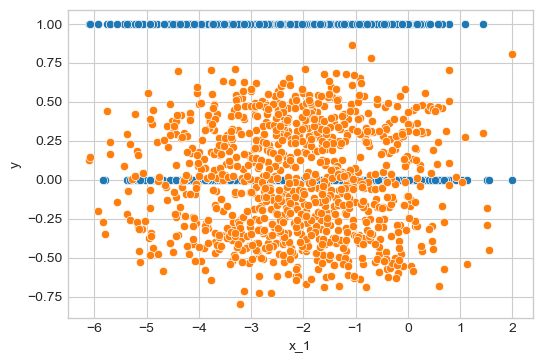

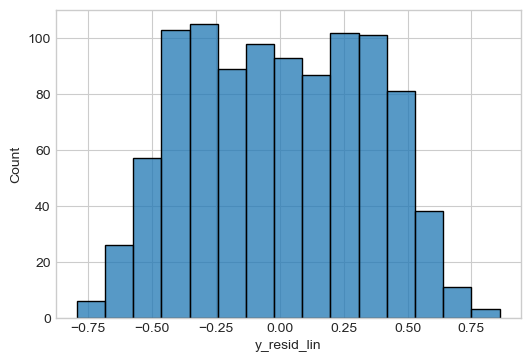

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y", x="x_1", ax=ax)
sns.scatterplot(data=df, y="y_resid_lin", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="y_resid_lin", ax=ax)
fig.show()


Model on residuals

In [ ]:
residuals_model = sklearn.linear_model.LinearRegression()
residuals_model.fit(X=df[["t_resid"]], y=df["y_resid_lin"])

print("True weights")
print(bias)
print(weights.flatten())

print("Est weights")
print(residuals_model.intercept_)
print(residuals_model.coef_)

df = df.drop(columns=["yt_resid_lin"], errors="ignore")
df = df.assign(
    yt_resid_lin=df["y_resid_lin"] - residuals_model.predict(df[["t_resid"]])
)


True weights
-0.3117738001983923
[-0.76856054  0.31923465  0.51529586  1.24731644  2.18529629]
Est weights
-8.903765625033873e-17
[-0.09964713]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


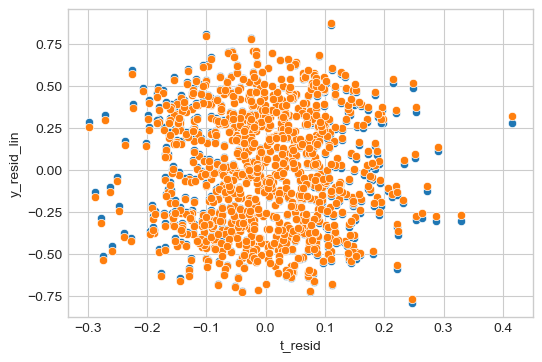

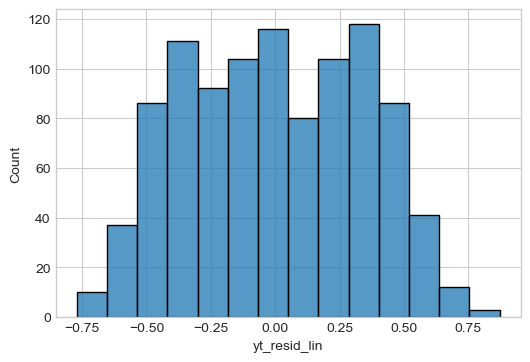

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y_resid_lin", x="t_resid", ax=ax)
sns.scatterplot(data=df, y="yt_resid_lin", x="t_resid", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="yt_resid_lin", ax=ax)
fig.show()


Using logistic regression instead

In [ ]:
outcome_model = sklearn.linear_model.LogisticRegression()
outcome_model.fit(X=df[x_cols], y=df["y"])
print("Est weights")
print(outcome_model.intercept_)
print(outcome_model.coef_)

df = df.drop(columns=["y_resid_log"], errors="ignore")
df = df.assign(y_resid_log=df["y"] - outcome_model.predict_proba(df[x_cols])[:, 1])


Est weights
[0.54691823]
[[-0.54650801  0.91730328  1.36103866  2.41557739]]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


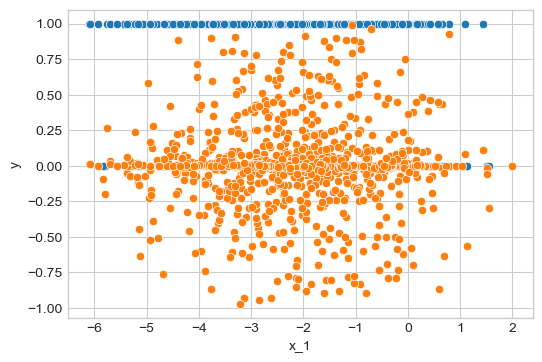

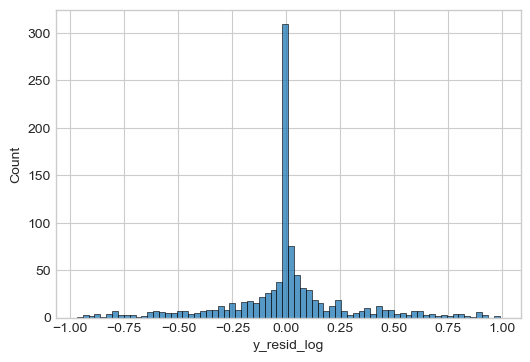

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y", x="x_1", ax=ax)
sns.scatterplot(data=df, y="y_resid_log", x="x_1", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="y_resid_log", ax=ax)
fig.show()


Model on residuals

In [ ]:
residuals_model = sklearn.linear_model.LinearRegression()
residuals_model.fit(X=df[["t_resid"]], y=df["y_resid_log"])

print("True weights")
print(bias)
print(weights.flatten())

print("Est weights")
print(residuals_model.intercept_)
print(residuals_model.coef_)

df = df.drop(columns=["yt_resid_log"], errors="ignore")
df = df.assign(
    yt_resid_log=df["y_resid_log"] - residuals_model.predict(df[["t_resid"]])
)


True weights
-0.3117738001983923
[-0.76856054  0.31923465  0.51529586  1.24731644  2.18529629]
Est weights
-1.7213951597286648e-06
[-0.09825136]


Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


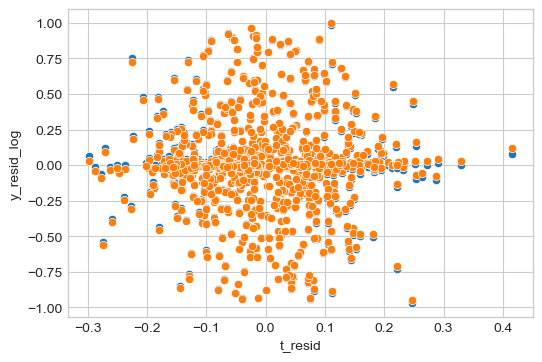

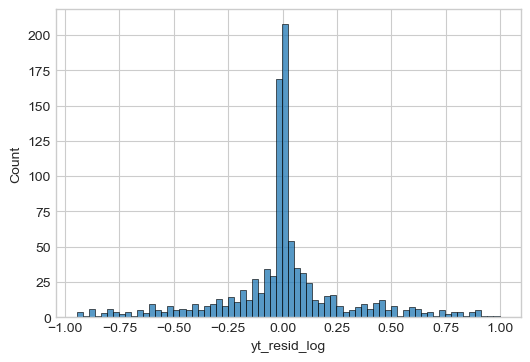

In [ ]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.scatterplot(data=df, y="y_resid_log", x="t_resid", ax=ax)
sns.scatterplot(data=df, y="yt_resid_log", x="t_resid", ax=ax)
fig.show()

fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(data=df, x="yt_resid_log", ax=ax)
fig.show()


The coefficient estimate is poor.

Are we estimating coefficients here or effect size? With a logistic model they are not the same.

Comparison to single logistic regression

Which gives a reasonable estimate.

In [ ]:
print("True weights")
print(bias)
print(weights.flatten())

logistic_model = sklearn.linear_model.LogisticRegression()
logistic_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(logistic_model.intercept_)
print(logistic_model.coef_)


True weights
-0.3117738001983923
[-0.76856054  0.31923465  0.51529586  1.24731644  2.18529629]
Est weights
[0.81111082]
[[-0.54313872 -0.0058963   0.91439587  1.36307298  2.42002985]]


Comparison to single linear regression

This gives the same results as the DoubleML model using linear regression for each step.
The coefficients have a different meaning the logits from the logistic regression model, so we don't expect them to be the same.

In [ ]:
print("True weights")
print(bias)
print(weights.flatten())

linear_model = sklearn.linear_model.LinearRegression()
linear_model.fit(X=df[["t"] + x_cols], y=df["y"])
print("Est weights")
print(linear_model.intercept_)
print(linear_model.coef_)


True weights
-0.3117738001983923
[-0.76856054  0.31923465  0.51529586  1.24731644  2.18529629]
Est weights
0.6147350557217326
[-0.09964713  0.06011852  0.08929568  0.11662495  0.20737488]


## Logistic weights to effect size

Weights - add 1 to the feature, whats the average effect before the sigmoid function? The effect is the same for every row, so no average needed.

Effect size - add 1 to the feature, whats the average change in probability? Average needed as sigmoid non-linear.

In [ ]:
df["y"].mean()


In [ ]:
import statsmodels.api as sm

sm_logit = sm.Logit(df["y"], sm.add_constant(df[["t"] + x_cols])).fit()
display(sm_logit.summary())

print("True weights")
print(bias)
print(weights.flatten())


Optimization terminated successfully.
         Current function value: 0.281443
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      994
Method:                           MLE   Df Model:                            5
Date:                Mon, 24 Jul 2023   Pseudo R-squ.:                  0.5930
Time:                        15:02:06   Log-Likelihood:                -281.44
converged:                       True   LL-Null:                       -691.58
Covariance Type:            nonrobust   LLR p-value:                4.761e-175
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1955      0.602      1.988      0.047       0.017       2.374
t             -1.1974      1.096     -1.092      0.275      -3.346       0.951
x_1            0.6266      1.100      0.569      0.569      -1.530       2.783
x_2            1.0447      0.339      3.083      0.002       0.381       1.709
x_3            1.4174      0.102     13.849      0.000       1.217       1.618
x_4            2.5309      0.185     13.667      0.000       2.168       2.894
==============================================================================
"""

True weights
-0.3117738001983923
[-0.76856054  0.31923465  0.51529586  1.24731644  2.18529629]


The marginal effect from the linear regression and the marginal effect here are very similar:

In [ ]:
sm_logit.get_margeff().margeff


array([-0.10622936,  0.05558722,  0.09268543,  0.12575076,  0.22453699])

Manual attempt with statsmodels

In [ ]:
import numpy as np
import statsmodels.api as sm

x1 = np.random.normal(5.0, 1.0, size=(1000))
x2 = np.random.normal(2.0, 1.0, size=(1000))

y = -4.0 + 0.5 * x1 - 0.25 * x2
Y = np.random.binomial(n=1, p=inv_logit(y))

logit_model = sm.Logit(Y, sm.add_constant(np.vstack([x1, x2]).transpose()))
logit_results = logit_model.fit(disp=0)
logit_coef = logit_results.params
est_margeff = logit_results.get_margeff().margeff
print(est_margeff)

d_x = 0.1

y_1 = -4.0 + 0.5 * (x1 + d_x) - 0.25 * x2
print((inv_logit(y_1).mean() - inv_logit(y).mean()) / d_x)

y_2 = -4.0 + 0.5 * x1 - 0.25 * (x2 + d_x)
print((inv_logit(y_2).mean() - inv_logit(y).mean()) / d_x)


[ 0.03295811 -0.02688559]
0.05614201627648585
-0.027360507807620005


## With EconML

EconML has DoubleML functionality. We can use that for convenience.

With a double ML linear regression model we can see the linear regression coefficients match the average marginal effect from a logistic regression model.

In [ ]:
import econml.dml

est = econml.dml.LinearDML(
    model_y=sklearn.linear_model.LinearRegression(),
    model_t=sklearn.linear_model.LinearRegression(),
)
est.fit(
    Y=Y,
    T=np.vstack([x1, x2]).transpose(),
)
display(est.summary())
est.const_marginal_effect()


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,0.034,0.011,3.227,0.001,0.014,0.055
cate_intercept|T1,-0.025,0.011,-2.365,0.018,-0.046,-0.004


array([[ 0.03446196, -0.02507123]])

In [ ]:
import sklearn.ensemble

est = econml.dml.DML(
    model_y=sklearn.ensemble.GradientBoostingRegressor(),
    model_t=sklearn.linear_model.LinearRegression(),
    model_final=sklearn.linear_model.LinearRegression(),
)
est.fit(
    Y=Y,
    T=np.vstack([x1, x2]).transpose(),
)
display(est.summary())
est.const_marginal_effect()


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


The final model has a nonzero intercept for at least one outcome; it will be subtracted, but consider fitting a model without an intercept if possible.
Final model doesn't have a `coef_stderr_` and `intercept_stderr_` attributes, only point estimates will be available.
Final model doesn't have a `coef_stderr_` and `intercept_stderr_` attributes, only point estimates will be available.


,point_estimate
cate_intercept|T0,0.032
cate_intercept|T1,-0.027


array([[ 0.03239939, -0.02703054]])

In [ ]:
est.const_marginal_ate()


array([ 0.03446196, -0.02507123])

In [ ]:
import econml.dml

est = econml.dml.LinearDML(
    model_y=sklearn.linear_model.LinearRegression(),
    model_t=sklearn.linear_model.LinearRegression(),
)
est.fit(
    Y=Y,
    T=np.vstack([x1, x2]).transpose(),
)
est.summary()


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|T0,0.032,0.011,2.988,0.003,0.011,0.053
cate_intercept|T1,-0.032,0.011,-2.951,0.003,-0.053,-0.011


In [ ]:
import econml.dml

n_samples = int(1e5)
est = econml.dml.LinearDML(
    model_y=sklearn.linear_model.LinearRegression(),
    model_t=sklearn.linear_model.LinearRegression(),
)
est.fit(
    Y=df["y"],
    T=df[["t"]],
    # X=df[x_cols],
    W=df[x_cols],
)


In [ ]:
est.summary()


Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,-0.081,0.104,-0.772,0.44,-0.285,0.124


In [ ]:
logit_results.get_margeff().margeff


array([0.12325373, 0.06025961])

In [ ]:
np.vstack([x1, x2]).transpose().shape


In [ ]:
Y_prob.shape


In [ ]:
data


,Y,x1,x2
0,0,4.574810,2.104410
1,0,5.019378,3.670580
2,0,5.434394,3.142573
3,0,4.102041,2.239514
4,0,6.843158,2.359220
...,...,...,...
995,0,4.562735,2.888333
996,1,4.585421,1.657695
997,0,3.932462,1.589575
998,1,4.069519,2.538115


100%|██████████| 1000/1000 [00:23<00:00, 41.96it/s]


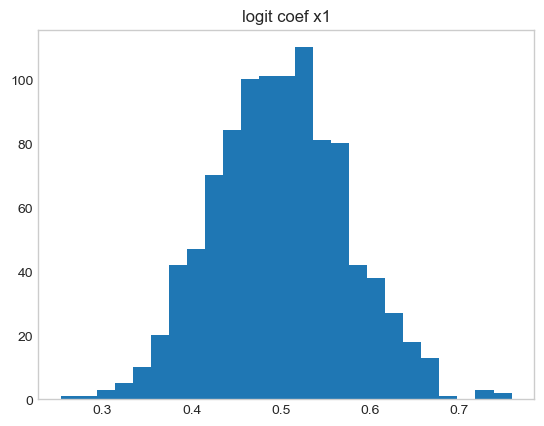

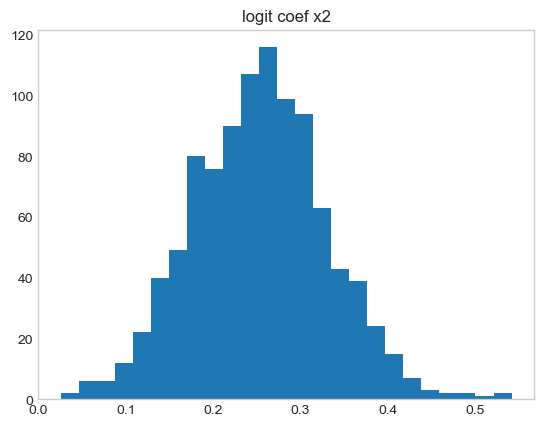

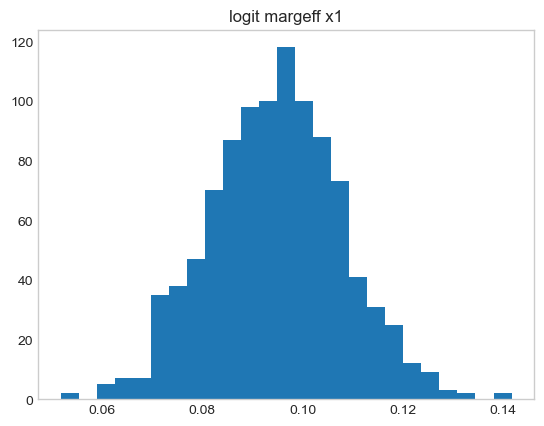

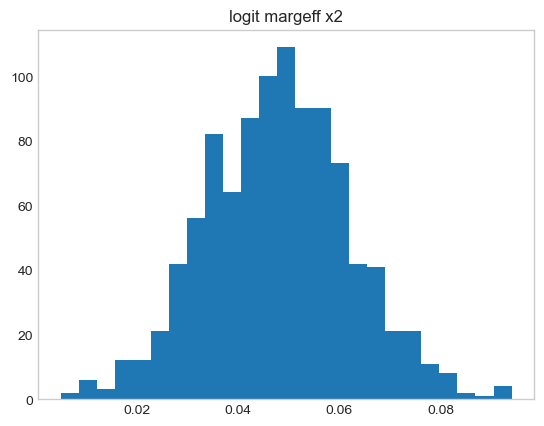

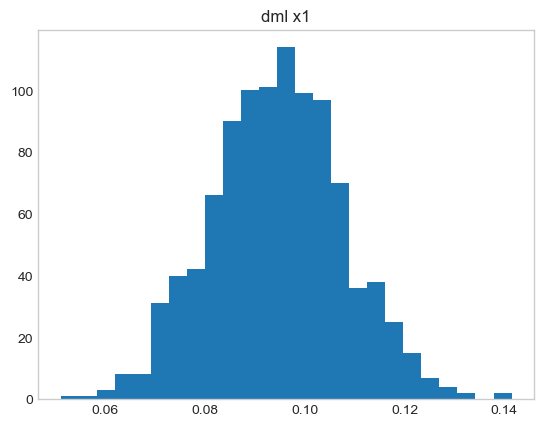

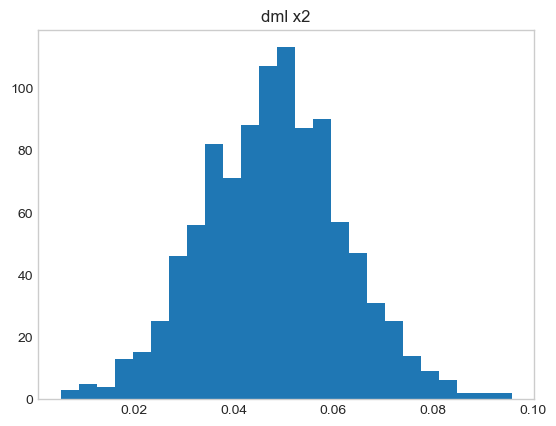

In [ ]:
# ref - https://github.com/py-why/EconML/issues/204

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

import econml.dml
from sklearn.linear_model import LinearRegression, LogisticRegression
import tqdm


def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))


logit_margeff_x1 = []
logit_margeff_x2 = []
logit_coef_x1 = []
logit_coef_x2 = []
dml_x1 = []
dml_x2 = []

for sim in tqdm.trange(1000):
    data = []
    for row in range(1000):
        x1 = np.random.normal(5.0, 1.0)
        x2 = np.random.normal(2.0, 1.0)

        Y_prob = sigmoid(-4.0 + 0.5 * x1 + 0.25 * x2)
        Y = np.random.choice([0, 1], p=[1 - Y_prob, Y_prob])

        data.append([Y, x1, x2])

    data = pd.DataFrame(data, columns=["Y", "x1", "x2"])

    # logit average marginal effects
    logit_model = smf.logit("Y ~ x1 + x2", data=data)
    logit_results = logit_model.fit(disp=0)
    x1_coef, x2_coef = logit_results.params.x1, logit_results.params.x2
    x1_margeff, x2_margeff = logit_results.get_margeff().margeff

    logit_margeff_x1.append(x1_margeff)
    logit_margeff_x2.append(x2_margeff)
    logit_coef_x1.append(x1_coef)
    logit_coef_x2.append(x2_coef)

    # dml estimates
    est = econml.dml.DML(
        model_y=LogisticRegression(),
        model_t=LinearRegression(),
        linear_first_stages=False,
        model_final=LinearRegression(fit_intercept=False),
        fit_cate_intercept=True,
        cv=4,
    )
    est.fit(Y=data["Y"].values, T=data[["x1", "x2"]].values, W=None, inference=None)
    te_pred = est.const_marginal_effect()[0]
    dml_x1.append(te_pred[0])
    dml_x2.append(te_pred[1])

plt.hist(logit_coef_x1, bins=25)
plt.grid()
plt.title("logit coef x1")
plt.show()

plt.hist(logit_coef_x2, bins=25)
plt.grid()
plt.title("logit coef x2")
plt.show()

plt.hist(logit_margeff_x1, bins=25)
plt.grid()
plt.title("logit margeff x1")
plt.show()

plt.hist(logit_margeff_x2, bins=25)
plt.grid()
plt.title("logit margeff x2")
plt.show()

plt.hist(dml_x1, bins=25)
plt.grid()
plt.title("dml x1")
plt.show()

plt.hist(dml_x2, bins=25)
plt.grid()
plt.title("dml x2")
plt.show()


# TODO

In the linear model case:

$$
Y = \theta(X) \cdot T + X\beta + \epsilon
$$
$$
T = a \cdot X_1 + b + \eta
$$


With a binary outcome:

$$
Y = \mathrm{bin} ( \theta(X) \cdot T + X\beta + \epsilon)
$$
$$
T = a \cdot X_1 + b + \eta
$$



Plot treatment with features